In [46]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [47]:
# load final clean dataset

df = pd.read_csv('merged_clean_data.csv')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77938 entries, 0 to 77937
Data columns (total 34 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   provincename                                                                       77938 non-null  object 
 1   Longitude                                                                          77938 non-null  float64
 2   Latitude                                                                           77938 non-null  float64
 3   Region.Name                                                                        77938 non-null  object 
 4   Date/Time                                                                          77938 non-null  object 
 5   Utilities                                                                          70102 non-null  flo

In [49]:
# convert 'Date/Time' to datetime format

df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# convert 'GeoUID' to string

df['GeoUID'] = df['GeoUID'].astype('str')

In [50]:
# set date time as index
df.set_index('Date/Time', inplace = True)

## All 5 provinces ##
**Forecasting: Mean Max Temp (°C)**

In [51]:
# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])
cat_cols = df.select_dtypes(include = ['object'])

# resample numeric data
resampled_num = num_cols.resample("M").mean()

# resample string data
resampled_cat = cat_cols.resample('M').apply(lambda x: x.value_counts().idxmax())

# combine resampled data
resampled_data_M = pd.concat([resampled_num, resampled_cat], axis = 1)
print(type(resampled_data_M))

# resampled_data = df.resample('M').mean()
# print(resampled_data)

<class 'pandas.core.frame.DataFrame'>


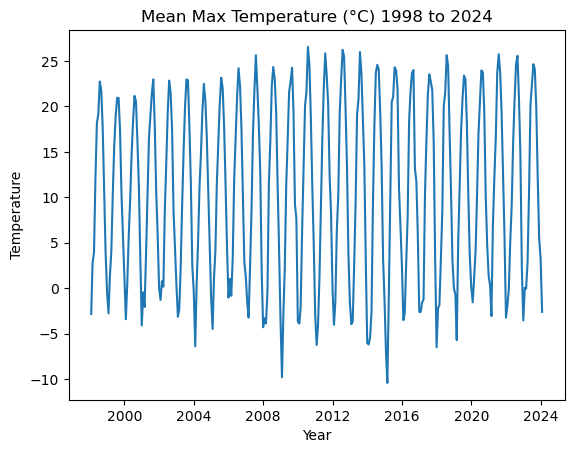

In [52]:
# plot mean max temp
plt.plot(resampled_data_M['Mean Max Temp (°C)'])
plt.title('Mean Max Temperature (°C) 1998 to 2024')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

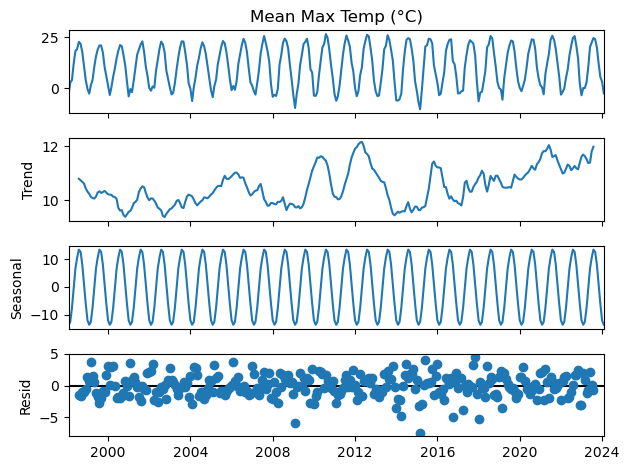

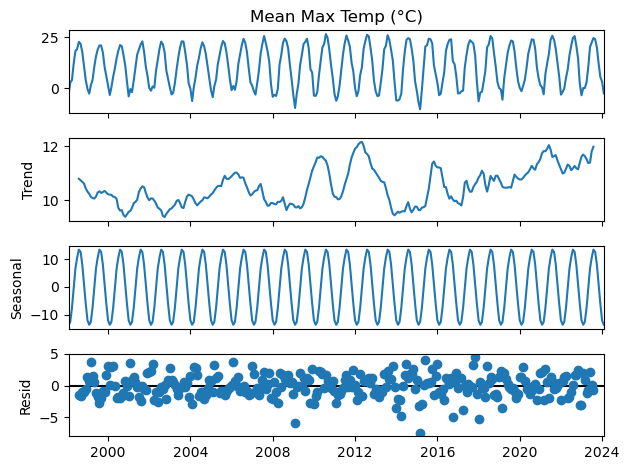

In [53]:
# seasonal decompose to separate different components (trend, seasonality, and residual)

decomp = seasonal_decompose(resampled_data_M['Mean Max Temp (°C)'],
                            period = 12)

decomp.plot()

Dicky-Fuller test

In [57]:
adfuller_result = adfuller(resampled_data_M['Mean Max Temp (°C)'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('Data is stationary. Can proceed with model creation.')

(-3.572539236030685, 0.006308248779781542, 16, 296, {'1%': -3.452636878592149, '5%': -2.8713543954331433, '10%': -2.5719993576515705}, 1226.7813956569635)
ADF Test Result:
Test Statistic: -3.572539236030685
P-value: 0.006308248779781542
Number of Lags: 16
Number of Observations: 296
Critical Values:
  1%: -3.452636878592149
  5%: -2.8713543954331433
  10%: -2.5719993576515705
Estimated maximized information criterion (aic): 1226.7813956569635
Data is stationary. Can proceed with model creation.


ACF and PACF

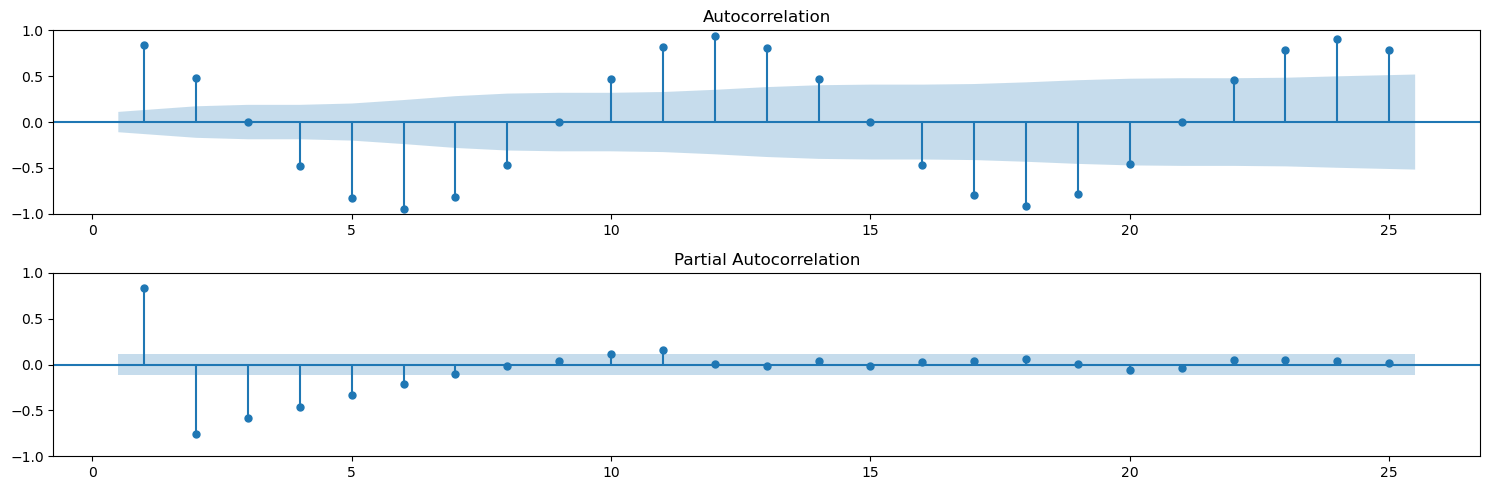

In [58]:
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))

# plot acf
plot_acf(resampled_data_M['Mean Max Temp (°C)'], zero = False, ax = ax1)

# plot pacf
plot_pacf(resampled_data_M['Mean Max Temp (°C)'],   zero = False, ax = ax2)

plt.tight_layout()
plt.show()

ARIMA model

In [14]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values from 0-4 (Use the partial autocorrelation)
for p in range(5):
# Loop over q values from 0-4 (Use the autocorrelation)
    for q in range(5):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = sm.tsa.ARIMA(resampled_data_M['Mean Max Temp (°C)'], order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\t

In [15]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q          AIC          BIC
13  2  3  1290.124450  1316.347872
22  4  2  1292.955578  1322.925203
17  3  2  1293.177881  1319.401304
23  4  3  1293.999393  1327.715221
12  2  2  1296.300248  1318.777467
14  2  4  1298.351242  1328.320867
18  3  3  1298.512326  1328.481951
24  4  4  1304.531630  1341.993662
19  3  4  1306.936793  1340.652622
21  4  1  1367.515940  1393.739362
16  3  1  1393.950876  1416.428095
20  4  0  1423.547617  1446.024837
11  2  1  1436.929680  1455.660696
15  3  0  1512.463567  1531.194583
10  2  0  1637.381445  1652.366258
4   0  4  1718.075567  1740.552787
7   1  2  1760.379744  1779.110760
9   1  4  1761.379585  1787.603007
3   0  3  1781.205601  1799.936617
6   1  1  1818.663351  1833.648164
8   1  3  1858.121507  1880.598726
2   0  2  1871.526488  1886.511301
5   1  0  1943.282386  1954.520996
1   0  1  2033.283640  2044.522250
0   0  0  2330.172568  2337.664974
    p  q          AIC          BIC
13  2  3  1290.124450  1316.347872
12  2  2  1296.30024

In [16]:
#to check the minimum value in the dataframe
order_df.AIC.min()

1290.1244501143124

In [17]:
#to check the minimum value in the dataframe
order_df.BIC.min()

1316.3478724480935

In [59]:
# Instantiate the model
#model = sm.tsa.ARIMA(milk_prod_diff, order=(9, 0, 4)) #order=(p,d,q)

model = sm.tsa.ARIMA(resampled_data_M['Mean Max Temp (°C)'], order=(2, 0, 3)) #order=(p,d,q)

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:     Mean Max Temp (°C)   No. Observations:                  313
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -638.062
Date:                Sun, 17 Mar 2024   AIC                           1290.124
Time:                        23:53:56   BIC                           1316.348
Sample:                    01-31-1998   HQIC                          1300.604
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5429      0.129     81.491      0.000      10.289      10.796
ar.L1          1.7320      0.001   2601.372      0.000       1.731       1.733
ar.L2         -0.9998      0.000  -3217.466      0.0

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Split data to train and test dataset

In [60]:
# split data to train and test

train = resampled_data_M.loc[resampled_data_M.index <= '2022-01-01']
test = resampled_data_M.loc[resampled_data_M.index > '2022-01-01']

In [62]:
#to fit the model after splitting the data

# Instantiate the model
model = sm.tsa.ARIMA(train['Mean Max Temp (°C)'], order=(2, 0, 3)) #order=(p,d,q)

# Fit the model
results_1 = model.fit()


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
#get the predictions
predictions = results_1.get_forecast(steps=36)
# Extract prediction mean
mean_predictions =predictions.predicted_mean

In [64]:
mean_predictions

2022-01-31    -3.672103
2022-02-28    -1.797250
2022-03-31     2.996295
2022-04-30     9.786496
2022-05-31    16.754163
2022-06-30    22.033002
2022-07-31    24.209508
2022-08-31    22.701452
2022-09-30    17.913635
2022-10-31    11.129227
2022-11-30     4.165868
2022-12-31    -1.111302
2023-01-31    -3.289225
2023-02-28    -1.785291
2023-03-31     2.996803
2023-04-30     9.775420
2023-05-31    16.734473
2023-06-30    22.009973
2023-07-31    24.189309
2023-08-31    22.689493
2023-09-30    17.913117
2023-10-31    11.140286
2023-11-30     4.185540
2023-12-31    -1.088290
2024-01-31    -3.269035
2024-02-29    -1.773332
2024-03-31     2.997330
2024-04-30     9.764378
2024-05-31    16.714820
2024-06-30    21.986977
2024-07-31    24.169129
2024-08-31    22.677534
2024-09-30    17.912580
2024-10-31    11.151312
2024-11-30     4.205172
2024-12-31    -1.065310
Freq: M, Name: predicted_mean, dtype: float64

In [65]:
test['Mean Max Temp (°C)']#.loc['2022-01-31':'2024-12-31']

Date/Time
2022-01-31    -1.902235
2022-02-28    -0.220802
2022-03-31     5.097507
2022-04-30     9.034053
2022-05-31    16.039724
2022-06-30    20.649357
2022-07-31    24.658194
2022-08-31    25.576209
2022-09-30    20.971759
2022-10-31    14.621617
2022-11-30     2.275261
2022-12-31    -3.565782
2023-01-31     0.030103
2023-02-28    -0.067712
2023-03-31     2.896828
2023-04-30    10.324771
2023-05-31    20.216312
2023-06-30    22.415759
2023-07-31    24.656140
2023-08-31    24.081518
2023-09-30    19.889953
2023-10-31    12.078007
2023-11-30     5.460168
2023-12-31     3.200644
2024-01-31    -2.620875
Freq: M, Name: Mean Max Temp (°C), dtype: float64

In [66]:
# to calculate MAPE and RSME
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

arima_MAE = mean_absolute_error(test['Mean Max Temp (°C)'].loc['2022-01-31':'2024-01-31'], mean_predictions.loc['2022-01-31':'2024-01-31'])
print('Arima_MAE:', arima_MAE)

arima_MAPE = mean_absolute_percentage_error(test['Mean Max Temp (°C)'].loc['2022-01-31':'2024-01-31'], mean_predictions.loc['2022-01-31':'2024-01-31'])
print('Arima_MAPE:', arima_MAPE)

arima_RMSE = np.sqrt(mean_squared_error(test['Mean Max Temp (°C)'].loc['2022-01-31':'2024-01-31'], mean_predictions.loc['2022-01-31':'2024-01-31']))
print('Arima_RMSE:', arima_RMSE)


Arima_MAE: 1.7230437301404666
Arima_MAPE: 5.947806601468377
Arima_RMSE: 2.064823236521601


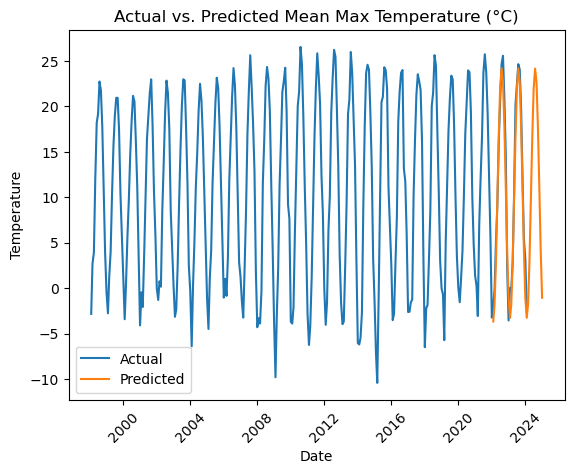

In [67]:
# plot actual data and predictions

plt.plot(resampled_data_M.index, resampled_data_M['Mean Max Temp (°C)'], label='Actual')

plt.plot(mean_predictions.index, mean_predictions.values, label='Predicted')

plt.title('Actual vs. Predicted Mean Max Temperature (°C)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)

plt.show()

## Ontario ##
**Forecasting: Agriculture**

In [26]:
# to filter ON province:

ontario = df[df['provincename'] == 'Ontario']

In [27]:
ontario = ontario[ontario.index.year < 2022]

In [28]:
# split data into number and object
num_cols = ontario.select_dtypes(include = ['number'])
cat_cols = ontario.select_dtypes(include = ['object'])

# to resample num data into monthly frequency
resampled_num = num_cols.resample(rule = 'M').mean()

# to resample cat data into monthly frequency
resampled_cat = cat_cols.resample(rule = 'M').apply(lambda x: x.value_counts().idxmax())

# combine resampled num and cat data
resampled_ON = pd.concat([resampled_num, resampled_cat], axis = 1)

In [29]:
ontario.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8701 entries, 1998-01-01 to 2021-12-01
Data columns (total 33 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   provincename                                                                       8701 non-null   object 
 1   Longitude                                                                          8701 non-null   float64
 2   Latitude                                                                           8701 non-null   float64
 3   Region.Name                                                                        8701 non-null   object 
 4   Utilities                                                                          8701 non-null   float64
 5   Construction                                                                       870

In [30]:
print(ontario.index.min())
print(ontario.index.max())

1998-01-01 00:00:00
2021-12-01 00:00:00


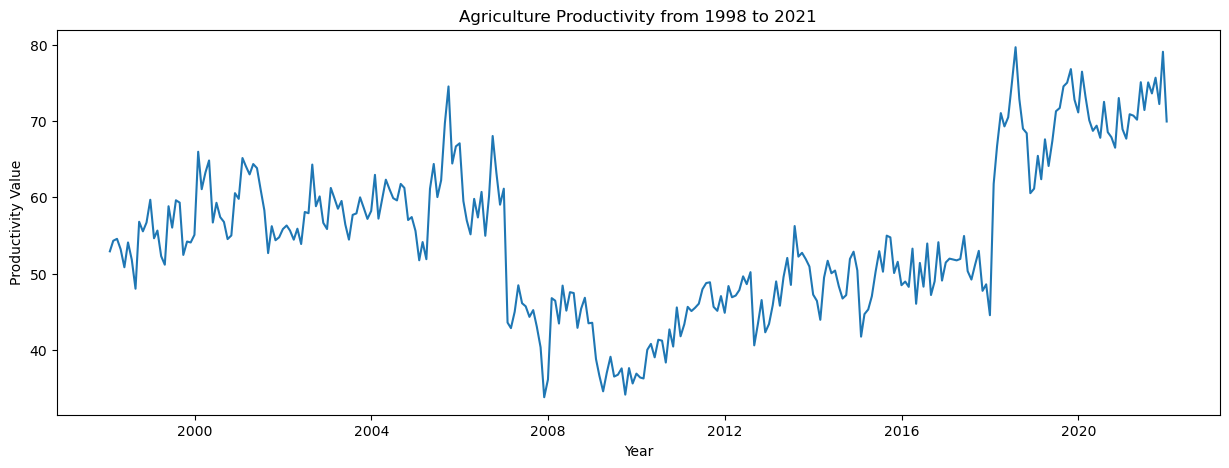

In [31]:
# plot the utililities
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
plt.title('Agriculture Productivity from 1998 to 2021')
plt.xlabel('Year')
plt.ylabel('Productivity Value')
plt.show()

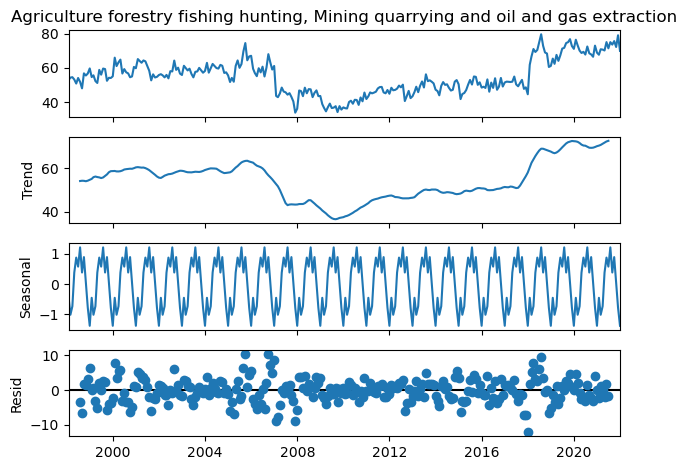

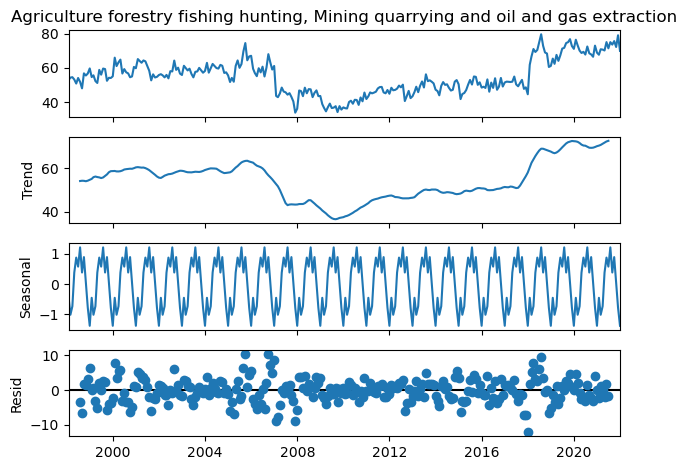

In [32]:
# to check different components (trend, seasonality, and residual)

decomp_ON = seasonal_decompose(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'],
                               period = 12)

decomp_ON.plot()

Dicky-Fuller Test

In [33]:
adfuller_result = adfuller(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
adfuller_result = adfuller(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('Data is stationary. Can proceed with model creation.')

(-2.2244320044855024, 0.19749783622467093, 1, 286, {'1%': -3.4534232986669546, '5%': -2.8716994185534745, '10%': -2.5721833625116144}, 1483.2074409605557)
ADF Test Result:
Test Statistic: -2.2244320044855024
P-value: 0.19749783622467093
Number of Lags: 1
Number of Observations: 286
Critical Values:
  1%: -3.4534232986669546
  5%: -2.8716994185534745
  10%: -2.5721833625116144
Estimated maximized information criterion (aic): 1483.2074409605557
Data is non-stationary. Needs to be converted to stationary data.


In [34]:
# transforming data to stationary data

# differencing

resampled_ON_diff = resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'].diff(periods = 2).dropna()
resampled_ON_diff

Date/Time
1998-03-31    1.640896
1998-04-30   -1.110992
1998-05-31   -3.733965
1998-06-30    0.890058
1998-07-31    1.002426
                ...   
2021-08-31    2.178425
2021-09-30    0.614057
2021-10-31   -1.394894
2021-11-30    3.409796
2021-12-31   -2.291200
Freq: M, Name: Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction, Length: 286, dtype: float64

In [35]:
adfuller_result = adfuller(resampled_ON_diff)
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('Data is stationary. Can proceed with model creation.')

(-4.411990290013513, 0.00028266033924551895, 14, 271, {'1%': -3.4547128138328875, '5%': -2.8722649771800155, '10%': -2.5724850011573914}, 1484.4594978642592)
ADF Test Result:
Test Statistic: -4.411990290013513
P-value: 0.00028266033924551895
Number of Lags: 14
Number of Observations: 271
Critical Values:
  1%: -3.4547128138328875
  5%: -2.8722649771800155
  10%: -2.5724850011573914
Estimated maximized information criterion (aic): 1484.4594978642592
Data is stationary. Can proceed with model creation.


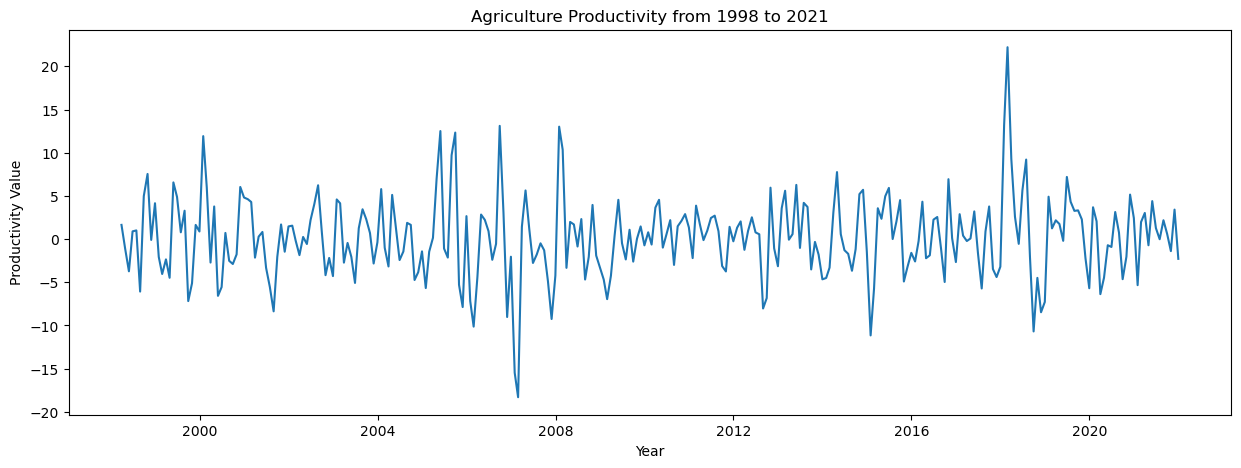

In [36]:
# plotting the transformed data

# plot the utililities
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON_diff)
plt.title('Agriculture Productivity from 1998 to 2021')
plt.xlabel('Year')
plt.ylabel('Productivity Value')
plt.show()

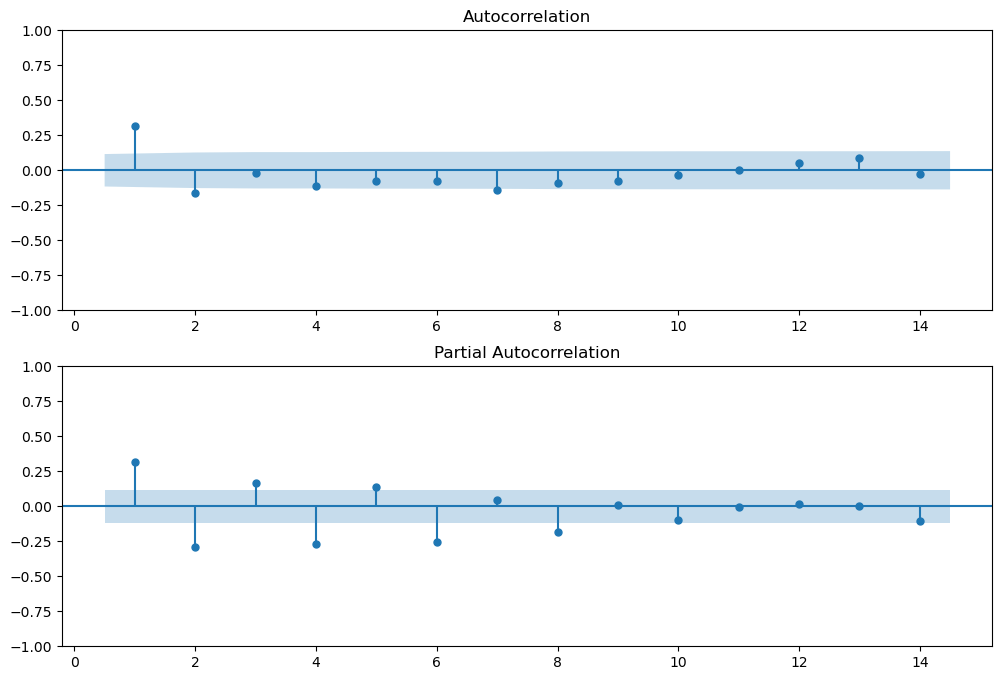

In [37]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(resampled_ON_diff, lags=14, zero=False, ax=ax1)
# plot_acf(resampled_ON_diff, zero=False, ax=ax1)

# Plot the PACF of on ax2
plot_pacf(resampled_ON_diff, lags=14, zero=False, ax=ax2)
# plot_pacf(resampled_ON_diff, zero=False, ax=ax2)

plt.show()

SARIMAX MODEL

In [39]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values (Use the partial autocorrelation)
for p in range(14):
# Loop over q values (Use the autocorrelation)
    for q in range(14):
        try:
            # Create and fit SARIMAX(p,d,q) model
            model = sm.tsa.SARIMAX(resampled_ON_diff, order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\state

In [40]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q          AIC          BIC
32  2  4  1565.441658  1594.689593
59  4  3  1566.219836  1599.123763
60  4  4  1566.410394  1602.970312
5   0  5  1566.918215  1592.510157
62  4  6  1567.063181  1610.935083
.. .. ..          ...          ...
56  4  0  1617.274432  1639.210383
42  3  0  1637.087636  1655.367595
28  2  0  1643.554348  1658.178315
14  1  0  1667.317647  1678.285623
0   0  0  1695.993818  1703.305802

[196 rows x 4 columns]
      p   q          AIC          BIC
2     0   2  1569.495489  1584.119456
16    1   2  1568.097078  1586.377037
15    1   1  1571.952662  1586.576630
30    2   2  1567.219652  1589.155603
29    2   1  1570.902784  1589.182743
..   ..  ..          ...          ...
193  13  11  1585.711275  1680.767062
180  12  12  1587.024276  1682.080063
194  13  12  1589.525255  1688.237034
195  13  13  1589.634709  1692.002480
0     0   0  1695.993818  1703.305802

[196 rows x 4 columns]


In [42]:
#to check the minimum value in the dataframe
print("AIC_min:", order_df.AIC.min())

#to check the minimum value in the dataframe
print('BIC_min:', order_df.BIC.min())

AIC_min: 1565.4416584279572
BIC_min: 1584.119455815274


In [41]:
# Instantiate the model

model = sm.tsa.SARIMAX(resampled_ON_diff, order=(2, 0, 4)) #order=(p,d,q)

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

                                                               SARIMAX Results                                                               
Dep. Variable:     Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction   No. Observations:                  286
Model:                                                                              SARIMAX(2, 0, 4)   Log Likelihood                -774.931
Date:                                                                               Sun, 17 Mar 2024   AIC                           1563.862
Time:                                                                                       23:49:12   BIC                           1589.454
Sample:                                                                                   03-31-1998   HQIC                          1574.120
                                                                                        - 12-31-2021                                         
Covari

In [42]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-48)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

confidence_intervals.head().T
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction']
upper_limits = confidence_intervals.loc[:,'upper Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction']

# Print best estimate predictions
print(mean_forecast)

Date/Time
2018-01-31    -1.868159
2018-02-28    12.183818
2018-03-31     2.872523
2018-04-30     1.024483
2018-05-31    -2.195906
2018-06-30    -1.542246
2018-07-31     1.632003
2018-08-31    -0.151058
2018-09-30    -7.020578
2018-10-31    -5.362755
2018-11-30    -1.075766
2018-12-31    -7.053480
2019-01-31     1.516113
2019-02-28     3.191211
2019-03-31    -0.522827
2019-04-30     4.882944
2019-05-31    -0.123655
2019-06-30     3.676642
2019-07-31     4.953293
2019-08-31     0.427022
2019-09-30     3.141274
2019-10-31    -0.635928
2019-11-30     1.058332
2019-12-31    -4.766914
2020-01-31    -1.831696
2020-02-29     1.721384
2020-03-31    -3.701273
2020-04-30    -4.064375
2020-05-31    -1.134354
2020-06-30    -0.528222
2020-07-31    -0.590195
2020-08-31     3.111674
2020-09-30    -1.757663
2020-10-31     0.026091
2020-11-30     1.050431
2020-12-31     5.172038
2021-01-31    -1.429212
2021-02-28    -0.510798
2021-03-31     3.913524
2021-04-30    -0.643512
2021-05-31     0.431101
2021-0

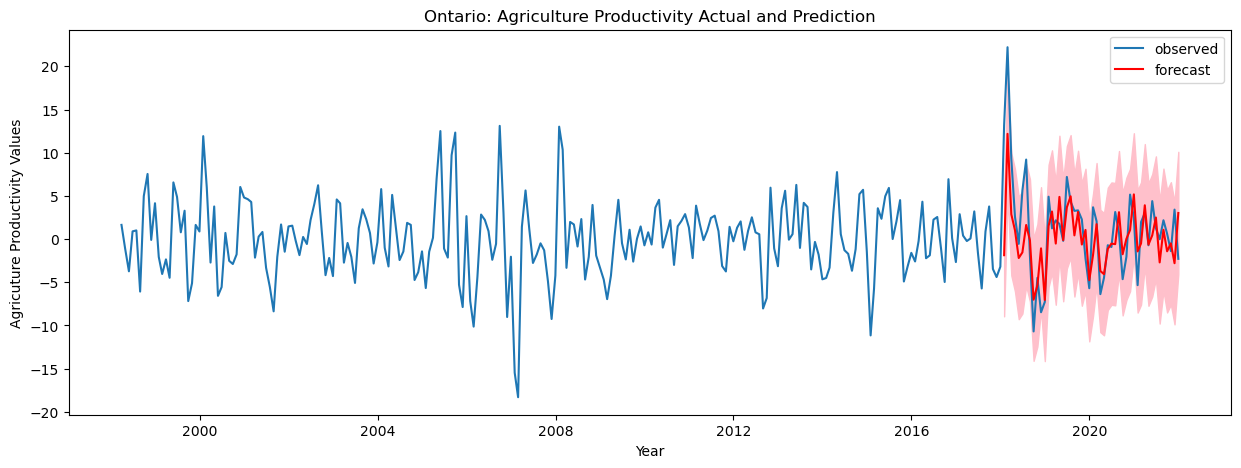

In [43]:
# plot the  data
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON_diff.index, resampled_ON_diff, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits,
               upper_limits, color='pink')

# set labels, legends and show plot
plt.title('Ontario: Agriculture Productivity Actual and Prediction')
plt.xlabel('Year')
plt.ylabel('Agricuture Productivity Values')
plt.legend()
plt.show()

In [44]:
# to calculate MAE, MAPE and RSME
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

sarimax_MAE = mean_absolute_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast)
print('Sarimax_MAE:', sarimax_MAE)

sarimax_MAPE = mean_absolute_percentage_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast)
print('Sarimax_MAPE:', sarimax_MAPE)

sarimax_RMSE = np.sqrt(mean_squared_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast))
print('Sarimax_RMSE:', sarimax_RMSE)


Sarimax_MAE: 3.0718825648925105
Sarimax_MAPE: 3.5399474047469717
Sarimax_RMSE: 4.190332666109481


IGNORE BELOW

Split data to train and test dataset

In [56]:
# split data to train and test

train = resampled_ON_diff.loc[resampled_ON_diff.index <= '2020-01-01']
test = resampled_ON_diff.loc[resampled_ON_diff.index > '2020-01-01']

In [57]:
#to fit the model after splitting the data

# Instantiate the model
model = sm.tsa.ARIMA(train, order=(1, 1, 2)) #order=(p,d,q)

# Fit the model
results = model.fit()


In [58]:
#get the predictions
predictions = results.get_forecast(steps=24)
# Extract prediction mean
mean_predictions =predictions.predicted_mean
print(mean_predictions)

2020-01-31   -1.047747
2020-02-29    0.411891
2020-03-31    0.078637
2020-04-30    0.154723
2020-05-31    0.137352
2020-06-30    0.141318
2020-07-31    0.140412
2020-08-31    0.140619
2020-09-30    0.140572
2020-10-31    0.140583
2020-11-30    0.140580
2020-12-31    0.140581
2021-01-31    0.140581
2021-02-28    0.140581
2021-03-31    0.140581
2021-04-30    0.140581
2021-05-31    0.140581
2021-06-30    0.140581
2021-07-31    0.140581
2021-08-31    0.140581
2021-09-30    0.140581
2021-10-31    0.140581
2021-11-30    0.140581
2021-12-31    0.140581
Freq: M, Name: predicted_mean, dtype: float64


In [59]:
test.loc['2020-01-31': '2021-12-31']

Date/Time
2020-01-31    3.679435
2020-02-29    2.061321
2020-03-31   -6.376970
2020-04-30   -4.479538
2020-05-31   -0.716047
2020-06-30   -0.913497
2020-07-31    3.130181
2020-08-31    0.742083
2020-09-30   -4.645830
2020-10-31   -2.043999
2020-11-30    5.147226
2020-12-31    2.429975
2021-01-31   -5.337960
2021-02-28    1.969515
2021-03-31    3.022793
2021-04-30   -0.717823
2021-05-31    4.392208
2021-06-30    1.269769
2021-07-31   -0.021380
2021-08-31    2.178425
2021-09-30    0.614057
2021-10-31   -1.394894
2021-11-30    3.409796
2021-12-31   -2.291200
Freq: M, Name: Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction, dtype: float64

In [60]:
# to calculate MAPE and RSME
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

arima_MAE = mean_absolute_error(test, mean_predictions)
print('Arima_MAE:', arima_MAE)

arima_MAPE = mean_absolute_percentage_error(test, mean_predictions)
print('Arima_MAPE:', arima_MAPE)

arima_RMSE = np.sqrt(mean_squared_error(test, mean_predictions))
print('Arima_RMSE:', arima_RMSE)


Arima_MAE: 2.648816948157504
Arima_MAPE: 1.27592026524311
Arima_RMSE: 3.178484983346455


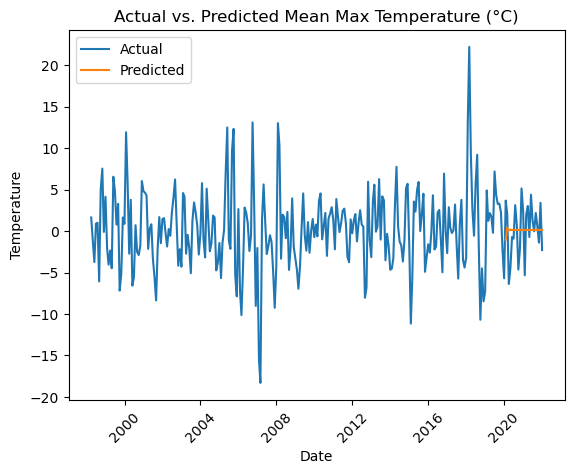

In [61]:
# plot actual data and predictions

plt.plot(resampled_ON_diff.index, resampled_ON_diff, label='Actual')

plt.plot(mean_predictions.index, mean_predictions.values, label='Predicted')

plt.title('Actual vs. Predicted Mean Max Temperature (°C)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)

plt.show()